Image formats founds: {'PNG'}
Unique image dimensions: {(51, 45)}
Channel distribution in images: {4: 16182}


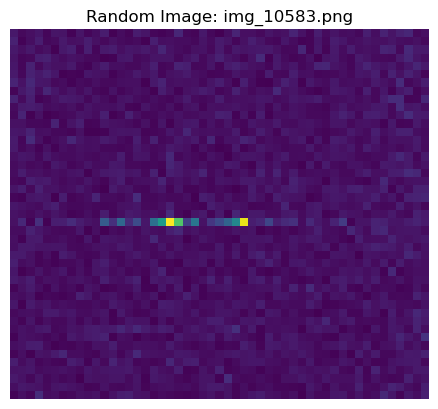

In [1]:
from PIL import Image
import os
import random
import matplotlib.pyplot as plt

train_images_directory = r'C:\Users\ryann\Desktop\Nouveau dossier\Projet ML\train_data_unlabeled\train_data_unlabeled'

image_stats = {
    'formats': set(),
    'dimensions': set(),
    'channel_counts': {}
}

image_files = os.listdir(train_images_directory)
for image_name in image_files:
    image_path = os.path.join(train_images_directory, image_name)
    with Image.open(image_path) as img:
        image_stats['formats'].add(img.format)
        image_stats['dimensions'].add(img.size)
        channels = len(img.getbands())
        image_stats['channel_counts'].setdefault(channels, 0)
        image_stats['channel_counts'][channels] += 1

print("Image formats founds:", image_stats['formats'])
print("Unique image dimensions:", image_stats['dimensions'])
print("Channel distribution in images:", image_stats['channel_counts'])

random_image_name = random.choice(image_files)
random_image_path = os.path.join(train_images_directory, random_image_name)
img = Image.open(random_image_path)
plt.imshow(img)
plt.title(f"Random Image: {random_image_name}")
plt.axis('off')
plt.show()


In [2]:
import pandas as pd

train_labels_path = r'C:\Users\ryann\Desktop\Nouveau dossier\Projet ML\y_train.csv'

train_labels_df = pd.read_csv(train_labels_path)

target_distribution = train_labels_df['target'].value_counts().reset_index()
target_distribution.columns = ['Target', 'Count']
target_distribution['Percentage'] = (target_distribution['Count'] / target_distribution['Count'].sum()) * 100

print(target_distribution)

   Target  Count  Percentage
0       1   5417   33.475467
1       3   4400   27.190706
2       2   4307   26.615993
3       0   2058   12.717835


Found 12945 validated image filenames belonging to 4 classes.
Found 3237 validated image filenames belonging to 4 classes.
Epoch 1/20


405/405 [==============================] - 232s 560ms/step - loss: 8.2596 - accuracy: 0.4915 - val_loss: 8.2477 - val_accuracy: 0.3883
Epoch 2/20
405/405 [==============================] - 229s 565ms/step - loss: 7.5900 - accuracy: 0.6545 - val_loss: 7.6151 - val_accuracy: 0.5341
Epoch 3/20
405/405 [==============================] - 226s 559ms/step - loss: 7.0853 - accuracy: 0.7326 - val_loss: 7.0511 - val_accuracy: 0.6506
Epoch 4/20
405/405 [==============================] - 233s 574ms/step - loss: 6.6133 - accuracy: 0.7852 - val_loss: 6.5941 - val_accuracy: 0.7062
Epoch 5/20
405/405 [==============================] - 227s 562ms/step - loss: 6.1894 - accuracy: 0.8187 - val_loss: 6.1923 - val_accuracy: 0.7334
Epoch 6/20
405/405 [==============================] - 229s 566ms/step - loss: 5.7865 - accuracy: 0.8479 - val_loss: 5.7880 - val_accuracy: 0.7723

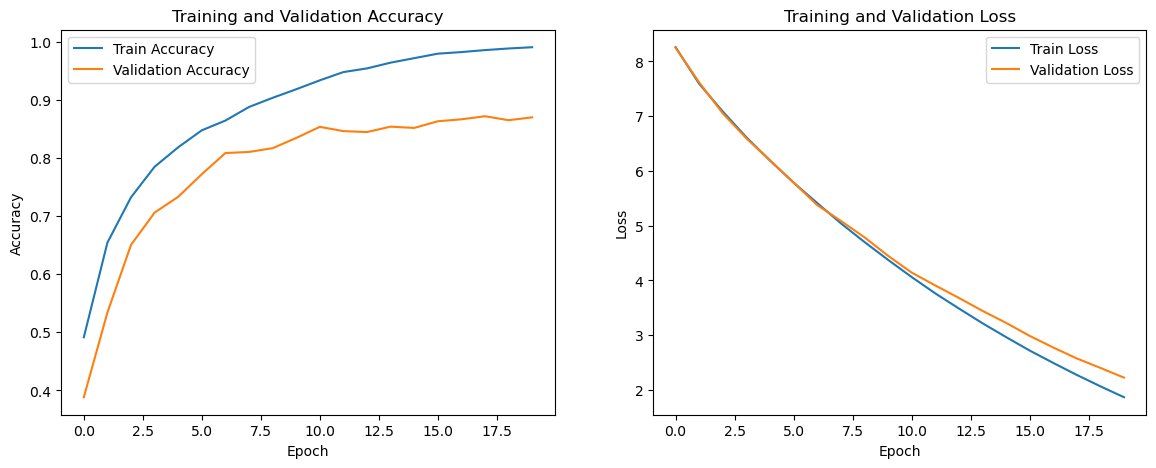

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Assuming train_labels_df is already defined with the columns 'id' and 'target'
train_images_directory = r'C:\Users\ryann\Desktop\Nouveau dossier\Projet ML\train_data_unlabeled\train_data_unlabeled'
train_labels_df['image_path'] = train_labels_df['id'].apply(lambda x: os.path.join(train_images_directory, f'img_{x+1}.png'))

# Splitting data into training and validation sets without stratification
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=123)

train_df['target'] = train_df['target'].astype(str)
val_df['target'] = val_df['target'].astype(str)

# Image data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow generators from dataframe
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='target',    
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Loading MobileNetV2 model with some layers unfrozen for fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Unfreeze layers from the conv7 block, for example
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Adding custom layers with Dropout and L2 regularization
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)  # Dropout
predictions = Dense(len(train_df['target'].unique()), activation='softmax')(x)

# Model creation and compilation with potentially lower learning rate for fine-tuning
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Increased patience for EarlyStopping

# Model training with an increased number of epochs
history = model.fit(
    train_generator,
    epochs=20,  # Increased number of epochs
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Display training and validation accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

102/102 [==============================] - 34s 325ms/step
Confusion Matrix
[[395   0   2   1]
 [  4 942 107  61]
 [  4  58 694 105]
 [  2  27  49 786]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       398
           1       0.92      0.85      0.88      1114
           2       0.81      0.81      0.81       861
           3       0.82      0.91      0.87       864

    accuracy                           0.87      3237
   macro avg       0.88      0.89      0.88      3237
weighted avg       0.87      0.87      0.87      3237



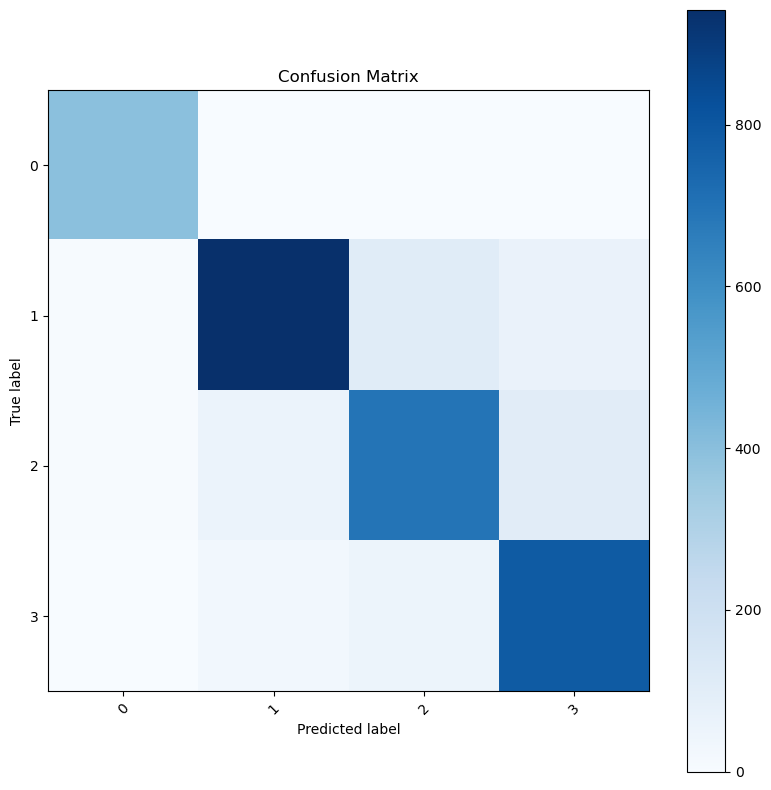

F1 Scores per Class
0: 0.983810709838107
1: 0.8799626342830454
2: 0.8102743724460013
3: 0.8651623555310953


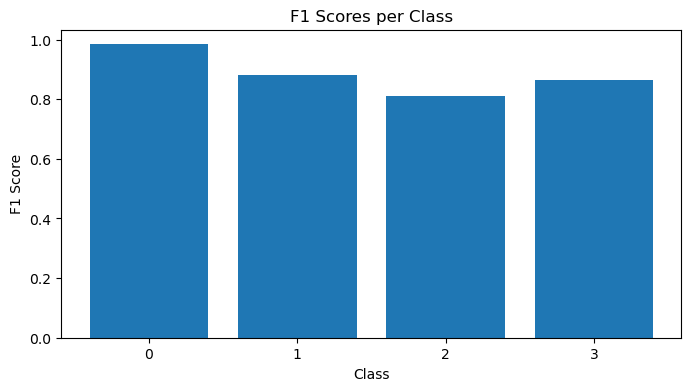

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# After training, evaluate the model on the validation set
val_generator.reset()  # Resetting the generator before prediction
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels of the validation set
y_true = val_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix')
print(conf_mat)

# Classification Report
class_labels = list(val_generator.class_indices.keys())  # Class labels
print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Plotting the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculating the F1 scores
f1_scores = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
f1_score_values = [f1_scores[label]['f1-score'] for label in class_labels]
print('F1 Scores per Class')
for label, score in zip(class_labels, f1_score_values):
    print(f"{label}: {score}")

# Plotting F1 scores
plt.figure(figsize=(8, 4))
plt.bar(class_labels, f1_score_values)
plt.title('F1 Scores per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()


In [11]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import numpy as np
import os
import pandas as pd

def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Paths for test images and example submission file
test_images_dir = "C:/Users/ryann/Desktop/Nouveau dossier/Projet ML/test_data_unlabeled/test_data_unlabeled"
submission_example_path = "C:/Users/ryann/Desktop/Nouveau dossier/Projet ML/submission_example.csv"

# Load and preprocess test images
test_images = [load_and_preprocess_image(os.path.join(test_images_dir, f)) for f in sorted(os.listdir(test_images_dir), key=lambda x: int(x.split('_')[1].split('.')[0]))]

# Predict the classes of the test images
predictions = model.predict(np.array(test_images))
predicted_classes = np.argmax(predictions, axis=1)

# Update the submission file
submission_df = pd.read_csv(submission_example_path)
submission_df['target'] = predicted_classes

# Save the submission file
submission_df.to_csv("C:/Users/ryann/Desktop/Nouveau dossier/Projet ML/submission.csv", index=False)
print("Saved submission file at 'C:/Users/ryann/Desktop/Nouveau dossier/Projet ML/submission.csv'")

150/150 [==============================] - 47s 310ms/step
Saved submission file at 'C:/Users/ryann/Desktop/Nouveau dossier/Projet ML/submission.csv'
